In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from aging.behavior.syllables import relabel_by_usage, assign_onsets
import colorcet as cc
from pathlib import Path

In [2]:
def age_map(string) -> int:
    '''returns age in weeks'''
    if '3m' in string:
        return 12
    if '6m' in string:
        return 24
    if '9m' in string:
        return 36
    if '12m' in string:
        return 52
    if '18m' in string:
        return 72
    if '22m' in string:
        return 90
    if '3w' in string:
        return 3
    if '5w' in string:
        return 5
    if '7w' in string:
        return 7
    if '9w' in string:
        return 9
    if 'Ontogeny' in string: #CRL females
        return 91

## upload data and housekeeping

In [3]:
## get syllable maps from male ontogeny
df_temp = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_05/ontogeny_males_syllable_df_v00.parquet')
df_temp,usage_map = relabel_by_usage(df_temp, return_map=True)

In [4]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_05/ontogeny_females_syllable_df_v00.parquet')

In [5]:
# relabel syllables by usage and add age
#df = relabel_by_usage(df, return_map=False)
df = assign_onsets(df)
df['relabeled_syllables'] = df['syllables'].map(usage_map)
df['age'] = df['age'].map(age_map)

In [6]:
df.age.unique()

array([ 5, 91, 72,  9, 12,  7, 24, 52,  3, 36])

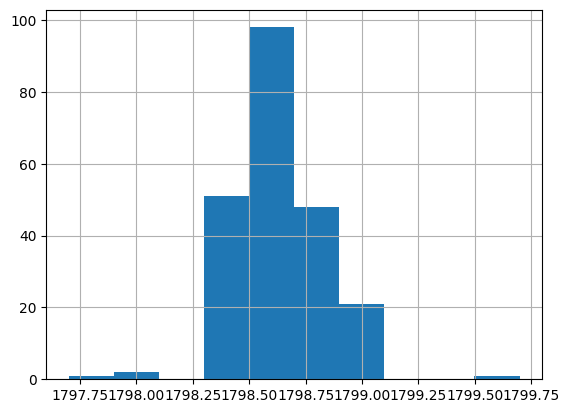

In [7]:
# clean up the data by removing short sessions
t = 600
session_length = df.groupby("uuid", sort=False)['timestamps'].max()
remove_uuids = session_length[session_length < t].index
session_length.hist()
df = df[~df['uuid'].isin(remove_uuids)]

In [8]:
# computer usage

In [9]:
usage_df = df.query('onsets').groupby(['age', 'subject_name', 'session_name','uuid'])['relabeled_syllables'].value_counts(normalize=True)
usage_df.name = 'usage'
usage_df = usage_df.reset_index()
usage_mtx = usage_df.pivot_table(values='usage', columns='relabeled_syllables', index=['age','subject_name','session_name', 'uuid']).fillna(0)

In [10]:
from collections import Counter
Counter(usage_mtx.index.get_level_values(0))

Counter({3: 24,
         5: 24,
         7: 24,
         24: 24,
         52: 24,
         72: 24,
         9: 23,
         12: 23,
         36: 16,
         91: 16})

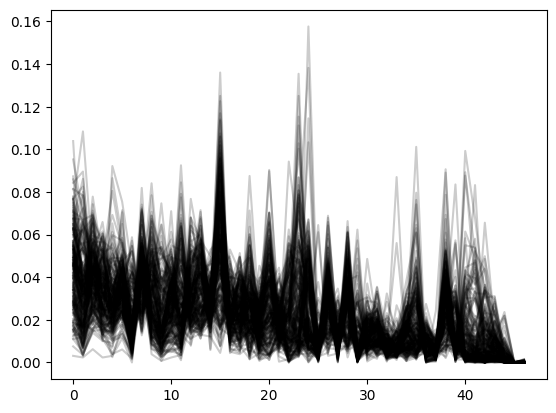

In [11]:
# remove sessions with abnormally high syllable usage
us = 0.2
usage_mtx = usage_mtx[~(usage_mtx > us).any(axis=1)]
plt.plot(usage_mtx.values.T, c='k', alpha=0.2);

In [12]:
um = usage_mtx.reset_index()
from collections import Counter
Counter(um.age)

Counter({3: 24,
         5: 24,
         7: 24,
         24: 24,
         52: 24,
         72: 24,
         9: 23,
         12: 23,
         36: 16,
         91: 16})

In [13]:
data_folder = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_05')
usage_mtx.to_parquet(data_folder / "ontogeny_females_clean_v1.parquet", engine='pyarrow') 

In [14]:
#get random 16 mice per age
#get random 16 mice for ages in which there are more than 16 mice
n=16
usage_mtx = usage_mtx.groupby('age').apply(lambda x: x.sample(n=n,replace=False) if len(x)>n else x.sample(n=len(x),replace=False)).reset_index(level=0, drop=True)

In [15]:
um = usage_mtx.reset_index()
from collections import Counter
Counter(um.age)

Counter({3: 16,
         5: 16,
         7: 16,
         9: 16,
         12: 16,
         24: 16,
         36: 16,
         52: 16,
         72: 16,
         91: 16})

In [16]:
data_folder = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_05')
usage_mtx.to_parquet(data_folder / "ontogeny_females_clean_v2.parquet", engine='pyarrow') 